In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
train = pd.read_csv(r'C:\Users\Rishima\Desktop\folder\food prediction\train.csv')

In [3]:
test = pd.read_csv(r'C:\Users\Rishima\Desktop\folder\food prediction\test_QoiMO9B.csv')

In [4]:
meal = pd.read_csv(r'C:\Users\Rishima\Desktop\folder\food prediction\meal_info.csv')

In [5]:
center = pd.read_csv(r'C:\Users\Rishima\Desktop\folder\food prediction\fulfilment_center_info.csv')

In [6]:
train = pd.merge(train, meal)
train = pd.merge(train, center)

In [7]:
test = pd.merge(test, meal)
test = pd.merge(test, center)

In [8]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


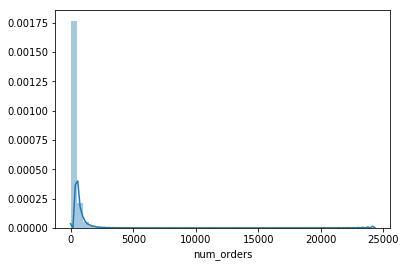

In [9]:
sns.distplot(train.num_orders)

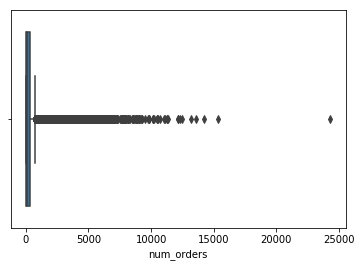

In [10]:
sns.boxplot(train.num_orders)

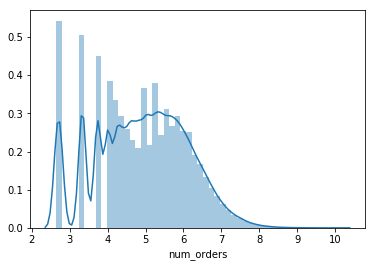

In [11]:
sns.distplot(np.log1p(train.num_orders))

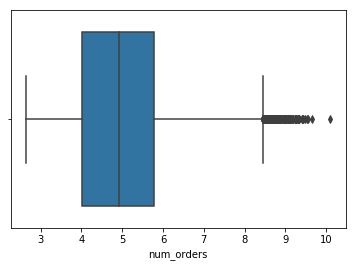

In [12]:
sns.boxplot(np.log1p(train.num_orders))

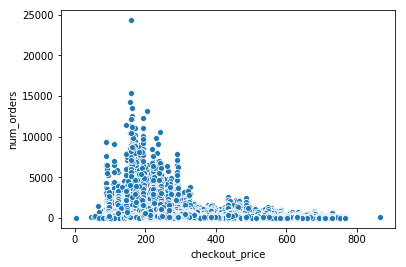

In [13]:
sns.scatterplot('checkout_price', 'num_orders', data=train)

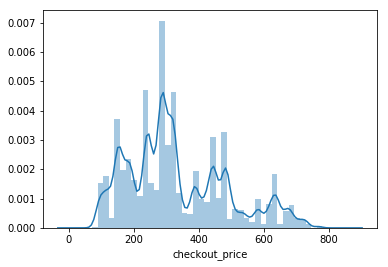

In [14]:
sns.distplot(train.checkout_price)

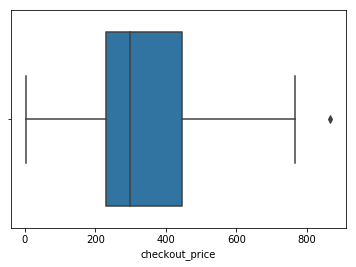

In [15]:
sns.boxplot(train.checkout_price)

# Feature Engineering

In [16]:
train['log_orders'] = np.log1p(train.num_orders)

In [17]:
train['region_code'] = train['city_code'].astype('str') + '_' + train['region_code'].astype('str')
train['combo'] = train['cuisine'].astype('str') + '_' + train['category'].astype('str')

test['region_code'] = test['city_code'].astype('str') + '_' + test['region_code'].astype('str')
test['combo'] = test['cuisine'].astype('str') + '_' + test['category'].astype('str')

In [18]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,log_orders,combo
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,647_56,TYPE_C,2.0,5.181784,Thai_Beverages
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,647_56,TYPE_C,2.0,5.780744,Thai_Beverages
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,647_56,TYPE_C,2.0,4.574711,Thai_Beverages
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,647_56,TYPE_C,2.0,5.099866,Thai_Beverages
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,647_56,TYPE_C,2.0,5.375278,Thai_Beverages


In [19]:
train.loc[train['checkout_price'] < train['base_price'], 'C'] = 1
train.loc[train['checkout_price'] > train['base_price'], 'C'] = 2
train.loc[train['checkout_price'] == train['base_price'], 'C'] = 0

test.loc[test['checkout_price'] < test['base_price'], 'C'] = 1
test.loc[test['checkout_price'] > test['base_price'], 'C'] = 2
test.loc[test['checkout_price'] == test['base_price'], 'C'] = 0

In [20]:
train_group=train.groupby(['center_id','meal_id'])['num_orders'].mean()
train_group=train_group.reset_index()
train_group=train_group.rename(columns={'num_orders':'avg_orders'})
train_new = pd.merge(train, train_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])

test_new = pd.merge(test, train_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])


In [21]:
test_new['avg_orders'].fillna(test_new['avg_orders'].median(), inplace=True)

In [22]:

train_new['center_id'] = train_new['center_id'].astype('object')
train_new['meal_id'] = train_new['meal_id'].astype('object')
train_new['op_area'] = train_new['op_area'].astype('int')


test_new['center_id'] = test_new['center_id'].astype('object')
test_new['meal_id'] = test_new['meal_id'].astype('object')
test_new['op_area'] = test_new['op_area'].astype('int')

In [23]:
train_new['op_area'] = train_new['center_id'].astype('str') + '_' + train_new['op_area'].astype('str')

test_new['op_area'] = test_new['center_id'].astype('str') + '_' + test_new['op_area'].astype('str')

In [ ]:
train_new.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,log_orders,combo,C,avg_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,647_56,TYPE_C,55_2,5.181784,Thai_Beverages,1.0,230.324138
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,647_56,TYPE_C,55_2,5.780744,Thai_Beverages,1.0,230.324138
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,647_56,TYPE_C,55_2,4.574711,Thai_Beverages,1.0,230.324138
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,647_56,TYPE_C,55_2,5.099866,Thai_Beverages,2.0,230.324138
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,647_56,TYPE_C,55_2,5.375278,Thai_Beverages,1.0,230.324138


In [ ]:
test_new.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,combo,C,avg_orders
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,647_56,TYPE_C,55_2,Thai_Beverages,1.0,230.324138
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,647_56,TYPE_C,55_2,Thai_Beverages,0.0,230.324138
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,647_56,TYPE_C,55_2,Thai_Beverages,1.0,230.324138
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,647_56,TYPE_C,55_2,Thai_Beverages,2.0,230.324138
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,647_56,TYPE_C,55_2,Thai_Beverages,2.0,230.324138


In [ ]:
train11 = train_new.drop(['id', 'center_id', 'category', 'cuisine', 'city_code', 'num_orders'], axis=1)

test11 = test_new.drop(['id', 'center_id', 'category', 'cuisine', 'city_code'], axis=1)

In [ ]:
train11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 13 columns):
week                     456548 non-null int64
meal_id                  456548 non-null object
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
region_code              456548 non-null object
center_type              456548 non-null object
op_area                  456548 non-null object
log_orders               456548 non-null float64
combo                    456548 non-null object
C                        456548 non-null float64
avg_orders               456548 non-null float64
dtypes: float64(5), int64(3), object(5)
memory usage: 48.8+ MB


In [ ]:
test11.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 12 columns):
week                     32573 non-null int64
meal_id                  32573 non-null object
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
region_code              32573 non-null object
center_type              32573 non-null object
op_area                  32573 non-null object
combo                    32573 non-null object
C                        32573 non-null float64
avg_orders               32573 non-null float64
dtypes: float64(4), int64(3), object(5)
memory usage: 3.2+ MB


# Applying Model

In [ ]:
# Base Model - 108

In [ ]:
train_dummy = pd.get_dummies(train11)
test_dummy = pd.get_dummies(test11)

In [ ]:
x = train_dummy.drop('log_orders', axis=1)
ytrain = train_dummy['log_orders']

In [ ]:
sc = StandardScaler()

In [ ]:
xtrain = pd.DataFrame(sc.fit_transform(x), columns=x.columns)

C:\Users\Rishima\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rishima\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
xtest = pd.DataFrame(sc.fit_transform(test_dummy), columns=test_dummy.columns)

C:\Users\Rishima\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Rishima\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [ ]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [100, 500, 900, 1100, 1500]

# Maximum depth of each tree
max_depth = [2, 3, 5, 10, 15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [2, 4, 6, 10]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss': loss,
                       'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [ ]:
model = GradientBoostingRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(estimator=model,
                               param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, 
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, 
                               return_train_score = True,
                               random_state=42)

In [ ]:
random_cv.fit(xtrain, ytrain)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 25 candidates, totalling 100 fits


In [ ]:
random_cv.best_estimator_